In [19]:
from tqdm import tqdm
from IPython.utils import io
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Activation

In [20]:
wb = pd.read_excel('LSVT_voice_rehabilitation.xlsx', 'Data')
features = pd.DataFrame(wb)
wb = pd.read_excel('LSVT_voice_rehabilitation.xlsx', 'Binary response')
class_label = pd.DataFrame(wb)
class1 = [float(i==1) for i in class_label.iloc[:,0]]
class2 = [float(i==2) for i in class_label.iloc[:,0]]
class_label = class_label.to_numpy().flatten()

In [21]:
for col in features.columns:
    features[col] = (features[col] - features[col].mean())/features[col].abs().max()
    
features

,Jitter->F0_abs_dif,Jitter->F0_dif_percent,Jitter->F0_PQ5_classical_Schoentgen,Jitter->F0_PQ5_classical_Baken,Jitter->F0_PQ5_generalised_Schoentgen,Jitter->F0_abs0th_perturb,Jitter->F0_CV,Jitter->F0_TKEO_mean,Jitter->F0_TKEO_std,Jitter->F0_TKEO_prc5,...,det_TKEO_std4_1_coef,det_TKEO_std4_2_coef,det_TKEO_std4_3_coef,det_TKEO_std4_4_coef,det_TKEO_std4_5_coef,det_TKEO_std4_6_coef,det_TKEO_std4_7_coef,det_TKEO_std4_8_coef,det_TKEO_std4_9_coef,det_TKEO_std4_10_coef
0,-0.066468,-0.082890,-0.082838,-0.033340,-0.061249,-0.020482,-0.020964,-0.038804,-0.034952,0.051697,...,0.007903,0.007720,0.007247,0.008839,0.008847,0.008944,0.007002,0.007106,0.007410,0.008703
1,-0.030866,-0.066103,-0.064835,0.067838,-0.081925,-0.019871,-0.020953,0.012543,0.063958,0.025804,...,0.098795,0.099252,0.098005,0.098818,0.099766,0.098824,0.098327,0.098659,0.099034,0.099850
2,0.158872,0.561317,0.566592,-0.000542,0.519678,0.026310,0.066991,-0.032220,-0.108107,-0.009437,...,-0.200743,-0.199414,-0.200822,-0.203238,-0.203230,-0.207259,-0.209097,-0.208821,-0.208217,-0.209700
3,-0.094019,-0.098523,-0.098027,0.005216,-0.080907,-0.028275,-0.021021,-0.075258,-0.112129,0.061130,...,-0.144775,-0.144617,-0.145622,-0.145107,-0.145004,-0.145269,-0.146545,-0.146343,-0.146087,-0.144950
4,-0.072234,-0.085704,-0.099164,0.308458,0.003853,-0.025916,-0.014811,-0.028485,-0.015284,0.057475,...,-0.013641,-0.011525,-0.016298,-0.013042,-0.013413,-0.013737,-0.015313,-0.015339,-0.014901,-0.014022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-0.052890,-0.051978,-0.050158,0.038097,-0.069764,-0.023081,-0.020920,-0.053079,-0.073146,0.046347,...,-0.051373,-0.050153,-0.049881,-0.048588,-0.048659,-0.049199,-0.048967,-0.049027,-0.048948,-0.048341
122,0.229291,0.230740,0.235550,0.099006,0.043501,-0.010882,-0.019039,0.024780,-0.017329,-0.092600,...,0.013112,0.015052,0.019401,0.020243,0.019213,0.018342,0.018686,0.017352,0.018778,0.018789
123,-0.073946,-0.073197,-0.072134,-0.050451,-0.060094,0.000215,-0.020981,-0.066567,-0.095212,0.056477,...,-0.089750,-0.089863,-0.091204,-0.091731,-0.091193,-0.091616,-0.092902,-0.092842,-0.092632,-0.090879
124,-0.055234,-0.069454,-0.067720,-0.009375,-0.075070,-0.022874,-0.020989,-0.037867,-0.034837,0.048065,...,0.011250,0.011519,0.010806,0.011183,0.011701,0.011451,0.011090,0.010679,0.010554,0.011329


In [22]:
classes = {'Acceptable': class1, 'Unacceptable': class2}
classes = pd.DataFrame(classes)
classes

,Acceptable,Unacceptable
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0
...,...,...
121,0.0,1.0
122,0.0,1.0
123,1.0,0.0
124,0.0,1.0


In [23]:
model = Sequential([
    
    InputLayer(input_shape=(features.shape[1])),
    
    Dense(7, activation='sigmoid'),
    
    Dense(5, activation='sigmoid'),
    
    Dense(2, activation='relu')
])

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

model.summary()

model.save_weights('model_weights/initial_weights_voice')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 7)                 2177      
                                                                 
 dense_4 (Dense)             (None, 5)                 40        
                                                                 
 dense_5 (Dense)             (None, 2)                 12        
                                                                 
Total params: 2,229
Trainable params: 2,229
Non-trainable params: 0
_________________________________________________________________


In [24]:
acc = 0
j = 0
for train_index, test_index in KFold(10).split(features):
    x_train, x_test = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train, y_test = classes.iloc[train_index,:], classes.iloc[test_index,:]
    model.load_weights('model_weights/initial_weights_voice')
    with io.capture_output() as captured:
        model.fit(x_train, y_train, epochs=1000)
    acc += model.evaluate(x_test, y_test)[1]
    j+=1

1/1 [==============================] - 0s 24ms/step - loss: 2.7946 - accuracy: 0.6667


In [25]:
acc/j

0.8166666686534881

In [29]:
model.fit(features, classes, epochs=500)

Epoch 1/500
4/4 [==============================] - 0s 5ms/step - loss: 2.5719 - accuracy: 0.9762
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 2.5718 - accuracy: 0.9762
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 2.5718 - accuracy: 0.9762
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 2.5718 - accuracy: 0.9683
Epoch 5/500
4/4 [==============================] - 0s 6ms/step - loss: 2.5718 - accuracy: 0.9683
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 2.5718 - accuracy: 0.9762
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 2.5717 - accuracy: 0.9683
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 2.5717 - accuracy: 0.9762
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 2.5717 - accuracy: 0.9762
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 2.5717 - accuracy: 0.9762
Epoch 11/500
4/4 [===========

In [30]:
grad_sum = 0
for col_name in tqdm(features.columns):
    pointFrame = features.loc[:, features.columns != col_name]
    for i in features[col_name]:
        pointFrame[col_name] = i*np.ones(len(features.index))
        points = tf.Variable(pointFrame, dtype='float')
        with tf.GradientTape() as tape:
            pred = model(points, training=False)
        grads = tape.gradient(pred, points)
        grad_sum += np.abs(grads.numpy())
saliency_order = np.argsort(np.sum(np.abs(grad_sum),0))

100%|██████████| 310/310 [03:16<00:00,  1.58it/s]


[]

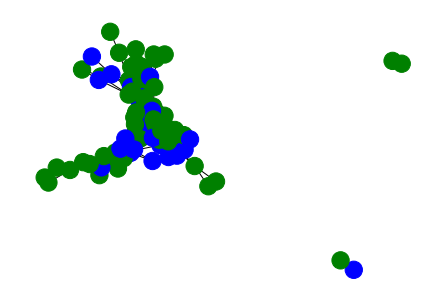

In [31]:
num_features = 35

salient_features = features.iloc[:,saliency_order[0:num_features]]
A = np.zeros((features.shape[0], features.shape[0]))
for i in features.index:
    for j in range(i):
        A[i,j] = np.linalg.norm(salient_features.iloc[i,:] - salient_features.iloc[j,:])
A = A + np.transpose(A)
# print(A)
# p = np.median(A).astype('int')
p = 0.5
A = (A <= p)
A = A - np.eye(A.shape[0])
rows, cols = np.where(A==1)
edges = zip(rows.tolist(), cols.tolist())
G = nx.Graph()
G.add_edges_from(edges, node_size=1)
color_map = np.array([])
acceptable = np.array([])
unacceptable = np.array([])
for node in G:
    if (class_label[node]==1):
        acceptable = np.append(acceptable, node)
        color_map = np.append(color_map, 'blue')
    else:
        unacceptable = np.append(unacceptable, node)
        color_map = np.append(color_map, 'green')
nx.draw(G, node_color=color_map)
plt.plot()

In [33]:
print(nx.is_connected(G)) # tells whether or not the graph is connected
print(nx.number_connected_components(G)) # number of different connected components
print(nx.density(G)) # this tells how close the graph is to being fully connected
# nx.clustering(G) # gives the clustering value of each vertex
print(nx.average_clustering(G)) # clustering value for the whole graph
print(nx.transitivity(G)) # 3* number of triangles in G/ number of connected triads in G

False
3
0.10386343216531896
0.5105322404126809
0.5435374149659864


[]

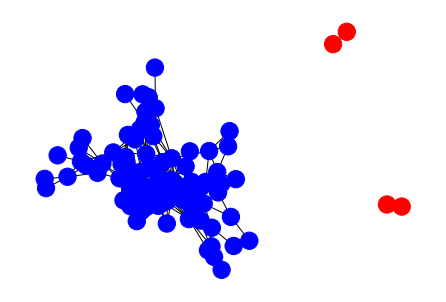

In [34]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len))
color_map_GC = np.array([])
for node in G:
    if node in giant_component:
        color_map_GC = np.append(color_map_GC, 'blue')
    else:
        color_map_GC = np.append(color_map_GC, 'red')
nx.draw(G, node_color=color_map_GC)
plt.plot()

In [35]:
print(f'Eccentricity of giant component: {nx.eccentricity(giant_component)}') # largest possible shortest path distance between a vertex and all other vertices
print(f'Diameter of giant component: {nx.diameter(giant_component)}') # maximum shortest distance between a pair of vertices in G, it is the largest possible eccentricity value of a vertex
print(f'Radius of giant component: {nx.radius(giant_component)}') #  minimum eccentricity value of a vertex

print(f'Degree centrality: \n{nx.degree_centrality(G)}') # number of edges incident upon a vertex
print(f'Maximum degree centrality: {max(nx.degree_centrality(G))}')
print(f'Degree histogram: {nx.degree_histogram(G)}')

# below gives us the different centrality measures for the vertices of the graphs
print(f'Eigenvector centrality: \n{nx.eigenvector_centrality(G)}')
print(f'Maximum eigenvector centrality: {max(nx.eigenvector_centrality(G))}')
print(f'Closeness centrality: \n{nx.closeness_centrality(G)}')
print(f'Maximum closeness centrality: {max(nx.closeness_centrality(G))}')
print(f'Betweeness centrality: \n{nx.betweenness_centrality(G)}')
print(f'Maximum betweeness centrality: {max(nx.betweenness_centrality(G))}')

Eccentricity of giant component: {0: 5, 9: 5, 17: 5, 19: 5, 20: 5, 21: 5, 24: 5, 25: 5, 28: 5, 32: 6, 33: 5, 38: 5, 39: 5, 69: 5, 78: 5, 84: 5, 91: 5, 97: 5, 103: 5, 106: 5, 112: 5, 118: 5, 1: 6, 13: 7, 22: 7, 34: 6, 37: 6, 54: 6, 57: 6, 60: 6, 74: 6, 3: 7, 6: 6, 30: 7, 72: 6, 87: 7, 90: 7, 100: 6, 113: 6, 114: 6, 115: 6, 117: 7, 120: 7, 123: 6, 4: 5, 31: 5, 73: 5, 81: 5, 5: 6, 23: 7, 27: 6, 29: 6, 36: 6, 92: 7, 116: 7, 71: 6, 93: 6, 102: 6, 8: 6, 45: 6, 88: 5, 89: 6, 94: 5, 105: 6, 35: 5, 109: 6, 10: 7, 51: 7, 53: 8, 63: 7, 82: 6, 11: 7, 49: 7, 65: 8, 80: 8, 47: 6, 83: 7, 15: 6, 18: 6, 99: 6, 108: 7, 119: 6, 48: 6, 46: 5, 111: 7, 41: 7, 61: 7, 40: 7, 124: 7, 101: 8, 110: 8, 50: 8, 52: 9, 76: 9, 77: 8, 56: 7, 64: 7, 70: 7, 79: 8, 58: 9, 85: 6, 66: 8}
Diameter of giant component: 9
Radius of giant component: 5
Degree centrality: 
{0: 0.2, 9: 0.2285714285714286, 17: 0.17142857142857143, 19: 0.1904761904761905, 20: 0.17142857142857143, 21: 0.1904761904761905, 24: 0.2571428571428572, 25: 0

In [36]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(salient_features)
print('***KMEANS***')
print('Number of Iterations: ', kmeans.n_iter_)
print('Cluster Centers: ', kmeans.cluster_centers_)
print('Inertia: ', kmeans.inertia_) # SSE
predicted_label = kmeans.labels_

***KMEANS***
Number of Iterations:  2
Cluster Centers:  [[-0.04739478  0.00281108  0.00302814  0.00237134  0.0028659   0.00287179
   0.00097516  0.00327202  0.00251458  0.00461013  0.00419137 -0.01588143
   0.01402761  0.00550967 -0.00257148  0.00217445  0.00347347  0.0027835
   0.00572123 -0.05214362 -0.04285974 -0.01176596 -0.04344348 -0.02281484
  -0.01238904 -0.04273805  0.02808553 -0.01994305 -0.02985798 -0.04309519
  -0.01437402 -0.00157978 -0.00281832 -0.01919317 -0.02634402]
 [ 0.61613208 -0.03654406 -0.03936582 -0.03082745 -0.03725665 -0.03733325
  -0.01267706 -0.04253629 -0.03268952 -0.05993168 -0.05448775  0.20645858
  -0.18235889 -0.07162571  0.03342928 -0.0282679  -0.04515507 -0.03618551
  -0.07437601  0.67786712  0.5571766   0.15295744  0.56476529  0.29659296
   0.16105747  0.55559465 -0.36511188  0.25925966  0.38815369  0.56023749
   0.18686222  0.0205371   0.03663811  0.24951126  0.34247231]]
Inertia:  81.85361395934693


In [38]:
compared_classes = class_label - 1
print('KMeans accuracy: ', np.count_nonzero(compared_classes!=predicted_label)/len(predicted_label))

KMeans accuracy:  0.5952380952380952


[]

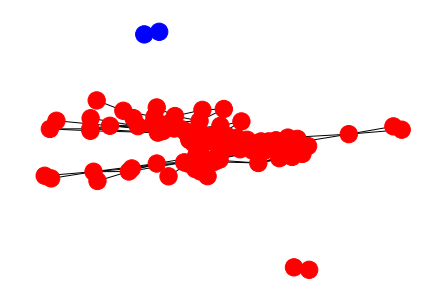

In [39]:
color_map_cluster = np.array([])
for node in G:
    if (predicted_label[node]==0):
        color_map_cluster = np.append(color_map_cluster, 'red')
    else:
        color_map_cluster = np.append(color_map_cluster, 'blue')
nx.draw(G, node_color=color_map_cluster)
plt.plot()